In [1]:
from elf.df_model3 import Model_PolicyValue

class ModelOptions:
    leaky_relu = False
    dim = 256
    bn = True
    bn_momentum = 0.1
    bn_eps = 1e-5
    num_block = 20
    gpu = 0
    use_data_parallel = False
    use_data_parallel_distributed = False

params = {"board_size": 19, "num_planes":18}

model = Model_PolicyValue(ModelOptions, params)

_replace_prefix = ["resnet.module,resnet", "init_conv.module,init_conv"]
replace_prefix = [
    item.split(",")
    for item in _replace_prefix
]
model.load(
    "elf/pretrained-go-19x19-v2.bin",
    omit_keys=[],
    replace_prefix=replace_prefix,
    check_loaded_options=False)
model = model.cuda()

In [2]:
from io_utils import *

ants = read_pkl('data/filtered_annotations.pkl')

In [3]:
from dlgo import goboard_fast as goboard
from dlgo.gotypes import Point, Player
from dlgo.encoders.sevenplane import SevenPlaneEncoder
from dlgo.gosgf.sgf_properties import interpret_go_point
def AGZ_features(ant):
    sgf_str = ant['sgf']
    game = goboard.GameState.new_game(19)
    move_seq = sgf_str.split(';')[1:-1]
    AGZ_feat = np.zeros((18, 19, 19), dtype=np.float64)
    encoder = SevenPlaneEncoder((19, 19))

    for mv, move_name in enumerate(move_seq):
        idx = move_name.index('[')
        col_s, row_s = move_name[idx+1], move_name[idx+2]
        col = ord(col_s) - 97
        row = 19 - ord(row_s) + 96
        if 'B' in move_name:
            game.board.place_stone(Player.black, Point(row+1, col+1))
            game.next_player = Player.white
        elif 'W' in move_name:
            game.board.place_stone(Player.white, Point(row+1, col+1))
            game.next_player = Player.black

        t = len(move_seq)-mv-1
        if t < 8:
            svp = encoder.encode(game)
            own = np.sum(svp[0:3], axis=0)
            opp = np.sum(svp[3:6], axis=0)
            if t % 2 == 1:
                own, opp = opp, own
            AGZ_feat[t*2] = own
            AGZ_feat[t*2+1] = opp

        if game.next_player == Player.black:
            AGZ_feat[16] = 1
        else:
            AGZ_feat[17] = 1

    return AGZ_feat

In [6]:
import torch
def tensor_input(ant):
    return torch.tensor(AGZ_features(ant)).unsqueeze(dim=0).type(torch.FloatTensor).cuda()

SZ[19];AB[dd];AB[pd];AB[jj];AB[dp];AB[pp];W[jq];B[jd];W[nq];B[qn];W[cf];B[fc];W[bd];B[cc];W[ci];B[pj];W[nc];B[pc];W[qf];B[pf];W[pg];B[qe];W[of];B[pe];W[ng];B[qg];W[qh];B[rf];W[ph];B[fq];W[cp];B[cq];W[co];B[bq];W[cl];B[lq];W[no];B[mp];W[np];B[ln];W[lr];B[nm];W[kq];B[nd];W[md];B[mc];W[lc];B[mb];W[lb];B[ld];W[me];B[nb];W[kd];B[le];W[ke];B[lf];W[jc];B[mf];W[ne];B[nf];W[oe];B[od];W[og];B[lh];W[mh];B[lg];W[qj];B[qk];W[rk];B[qi];W[rj];B[rh];W[oj];B[pk];W[pi];B[nj];W[ri];B[ok];W[rm];B[rn];W[oi];B[si];W[sj];B[sl];W[sh];B[rg];W[mi];B[ki];W[lj];B[mk];W[kk];B[il];W[jk];B[ik];W[rl];B[sm];W[km];B[jm];W[kj];B[ji];W[kn];B[kl];W[ll];B[jl];W[lm];B[lk];W[pm];B[on];W[qm];B[pn];W[nl];B[ml];W[ol];B[mm];W[nk];B[mj];W[li];B[ni];W[nh];B[mn];


<AxesSubplot:>

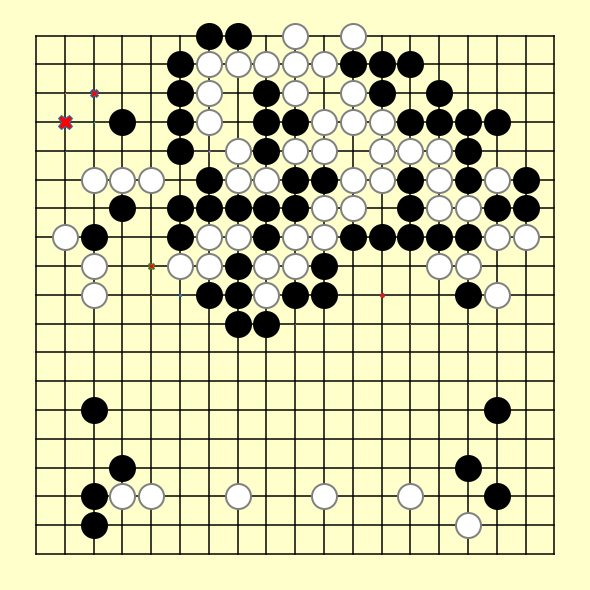

In [20]:
# thank god

import numpy as np
k = 512
move_probs = model(tensor_input(ants[k]))["pi"]
move = move_probs.argmax().item()
mv  = np.zeros((19, 19))
for m in range(19*19):
    mv[m//19][m%19] = move_probs[0][m]
    
#print(move_probs[0])
    
from visual_utils import *
print(ants[k]['sgf'])
draw_go_board(np.rot90(ants[k]['board_state'][0]), np.rot90(ants[k]['board_state'][1]), mv*40)